## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn import neighbors
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Pre-Processing

In [2]:
#import df
train_undum_df = pd.read_csv('./Data/train_undum_df.csv', index_col=0)
test_undum_df = pd.read_csv('./Data/test_undum_df.csv', index_col=0)

In [3]:
#assign predictor and target variables
y = train_undum_df['SalePrice'].apply(np.log)
X = train_undum_df.drop(["SalePrice"], axis = 1)

In [4]:
#train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Random Forest

In [5]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [6]:
#Baseline Values
train_baseline_rf = rf.predict(X_train)
RMSE_train = np.sqrt(mean_squared_error(y_train, train_baseline_rf))

test_baseline_rf = rf.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_test,test_baseline_rf))

print("Baseline Values: ")
print("R^2 for train data is: %.3f" %(rf.score(X_train, y_train)))
print("R^2 for test data is: %.3f" %(rf.score(X_test,y_test)))
print("-" * 50)
print("RMSE for train data is: %.3f" % RMSE_train)
print("RMSE for test data is: %.3f" % RMSE_test)

Baseline Values: 
R^2 for train data is: 0.980
R^2 for test data is: 0.880
--------------------------------------------------
RMSE for train data is: 0.057
RMSE for test data is: 0.136


In [8]:
#hyperparameter tuning using grid search
# grid_para_forest = {'n_estimators': [150,300,450,600,750,900],
#                    'max_depth': [40,50,60,70],
#                    'max_features' : [15,20,25]}

# grid_para_forest = {'n_estimators': [600,700,800,900,1000,1100],
#                    'max_depth': [40,50,60,70],
#                    'max_features' : [5,10,15,20]}

grid_para_forest = {'criterion': ['mse'],
                    'min_samples_split': [2,3],
                    'max_depth': [20,25,30],
                    'n_estimators': [200,300,400,500],
                    'min_samples_leaf':[1,2],
                    'max_leaf_nodes':[None],
                    'max_samples': [None],
                    'bootstrap': [False],
                    'max_features': ['sqrt', 8, 15, 20],
                    'ccp_alpha': [0.00,0.02],
                    'random_state' :[42]}

In [9]:
grid_search_forest = GridSearchCV(rf, grid_para_forest, cv=5, n_jobs=5, scoring='r2', verbose=1, return_train_score=True)
grid_search_forest.fit(X_train, y_train)

print("RF Grid Search Best params: ", grid_search_forest.best_params_)
print("RF Grid Search Best score: ", grid_search_forest.best_score_)
print("RF Grid Search Best estimators: ", grid_search_forest.best_estimator_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  4.8min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 12.1min
[Parallel(n_jobs=5)]: Done 1920 out of 1920 | elapsed: 13.1min finished


RF Grid Search Best params:  {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 8, 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300, 'random_state': 42}
RF Grid Search Best score:  0.8746139779812527
RF Grid Search Best estimators:  RandomForestRegressor(bootstrap=False, max_depth=20, max_features=8,
                      min_samples_split=3, n_estimators=300, random_state=42)


In [10]:
best_RF = grid_search_forest.best_estimator_

y_train_pred_rf = best_RF.predict(X_train)
RMSE_train = np.sqrt(mean_squared_error(y_train,y_train_pred_rf))

y_test_pred_rf = best_RF.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_test,y_test_pred_rf))


print("R^2 for train data is: %.3f" %(grid_search_forest.score(X_train, y_train)))
print("R^2 for test data is: %.3f" %(grid_search_forest.score(X_test,y_test)))
print("-" * 50)
print('RMSE for train data is: %.3f' % RMSE_train)
print('RMSE for test data is: %.3f' % RMSE_test)

R^2 for train data is: 1.000
R^2 for test data is: 0.899
--------------------------------------------------
RMSE for train data is: 0.009
RMSE for test data is: 0.125


In [11]:
# best parameters with lowered max_depth
rf2 = RandomForestRegressor(bootstrap= False,
                    ccp_alpha= 0.0,
                    criterion= 'mse',
                    max_depth= 6,
                    max_features= 8,
                    max_leaf_nodes= None,
                    max_samples= None,
                    min_samples_leaf= 1,
                    min_samples_split= 2,
                    n_estimators= 500,
                    random_state= 42)

rf2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=6, max_features=8,
                      n_estimators=500, random_state=42)

In [12]:
#Baseline Values
train_baseline_rf2 = rf2.predict(X_train)
RMSE_train2 = np.sqrt(mean_squared_error(y_train, train_baseline_rf2))

test_baseline_rf2 = rf2.predict(X_test)
RMSE_test2 = np.sqrt(mean_squared_error(y_test,test_baseline_rf2))

print("Baseline Values: ")
print("R^2 for train data is: %.3f" %(rf2.score(X_train, y_train)))
print("R^2 for test data is: %.3f" %(rf2.score(X_test,y_test)))
print("-" * 50)
print("RMSE for train data is: %.3f" % RMSE_train2)
print("RMSE for test data is: %.3f" % RMSE_test2)

Baseline Values: 
R^2 for train data is: 0.932
R^2 for test data is: 0.886
--------------------------------------------------
RMSE for train data is: 0.105
RMSE for test data is: 0.133


Text(0, 0.5, 'Features')

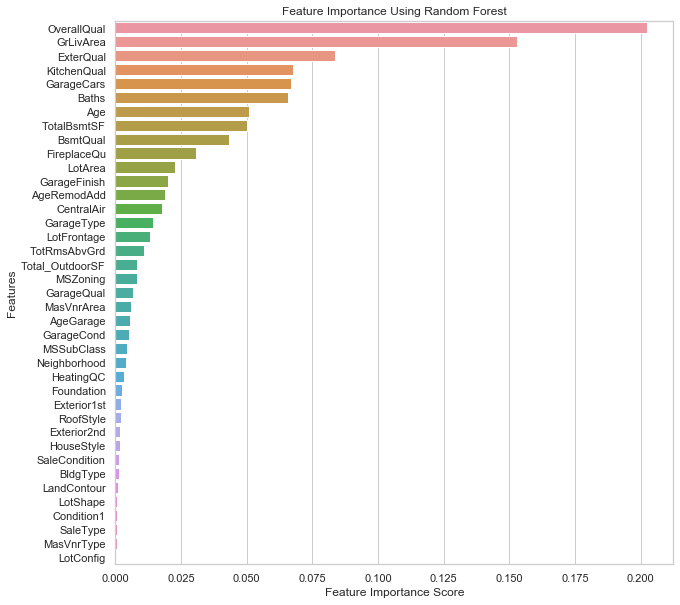

In [13]:
sorted_importance = sorted(zip(X.columns, rf2.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance Using Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

## Gradient Boosting

In [14]:
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)

GradientBoostingRegressor()

In [15]:
#Baseline Values
train_baseline_rf = rf.predict(X_train)
RMSE_train = np.sqrt(mean_squared_error(y_train, train_baseline_rf))

test_baseline_rf = rf.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_test,test_baseline_rf))

print("Baseline Values: ")
print("R^2 for train data is: %.3f" %(rf.score(X_train, y_train)))
print("R^2 for test data is: %.3f" %(rf.score(X_test,y_test)))
print("-" * 50)
print("RMSE for train data is: %.3f" % RMSE_train)
print("RMSE for test data is: %.3f" % RMSE_test)

Baseline Values: 
R^2 for train data is: 0.980
R^2 for test data is: 0.880
--------------------------------------------------
RMSE for train data is: 0.057
RMSE for test data is: 0.136


In [16]:
grid_para_gb = {'n_estimators': [200,300,400,500,600,700],
                   'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                   'max_depth':range(1,8),
                   'max_features' : [7,8,9]}


In [17]:
grid_search_gb = GridSearchCV(gbm, grid_para_gb, cv=10, n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train, y_train)

print("RF Grid Search Best params: ", grid_search_gb.best_params_)
print("RF Grid Search Best score: ", grid_search_gb.best_score_)
print("RF Grid Search Best estimators: ", grid_search_gb.best_estimator_)

Fitting 10 folds for each of 756 candidates, totalling 7560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 7560 out of 7560 | elapsed: 13.2min finished


RF Grid Search Best params:  {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 9, 'n_estimators': 700}
RF Grid Search Best score:  0.8915432836831787
RF Grid Search Best estimators:  GradientBoostingRegressor(learning_rate=0.01, max_depth=5, max_features=9,
                          n_estimators=700)


In [18]:
best_GB = grid_search_gb.best_estimator_

y_train_pred_gb = best_GB.predict(X_train)
RMSE_train = np.sqrt(mean_squared_error(y_train,y_train_pred_gb))

y_test_pred_gb = best_GB.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_test,y_test_pred_gb))


print("R^2 for train data is: %.3f" %(grid_search_gb.score(X_train, y_train)))
print("R^2 for test data is: %.3f" %(grid_search_gb.score(X_test,y_test)))
print("-" * 50)
print('RMSE for train data is: %.3f' % RMSE_train)
print('RMSE for test data is: %.3f' % RMSE_test)

R^2 for train data is: 0.980
R^2 for test data is: 0.902
--------------------------------------------------
RMSE for train data is: 0.057
RMSE for test data is: 0.123


Text(0, 0.5, 'Features')

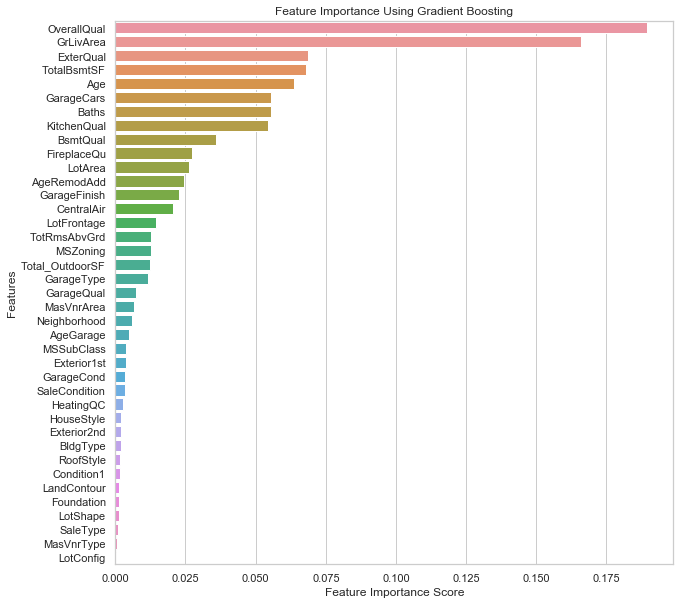

In [19]:
sorted_importance = sorted(zip(X.columns, best_GB.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance Using Gradient Boosting')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

In [48]:
#manually lowered max depth 
gbm2 = GradientBoostingRegressor(n_estimators=700,
                                 learning_rate=0.01,
                                 max_depth=2,
                                 max_features=9)

gbm2.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=2, max_features=9,
                          n_estimators=700)

In [50]:
train_baseline_gbm2 = gbm2.predict(X_train)
RMSE_train2 = np.sqrt(mean_squared_error(y_train, train_baseline_gbm2))

test_baseline_gbm2 = gbm2.predict(X_test)
RMSE_test2 = np.sqrt(mean_squared_error(y_test,test_baseline_gbm2))

print("Final Values: ")
print("R^2 for train data is: %.3f" %(gbm2.score(X_train, y_train)))
print("R^2 for test data is: %.3f" %(gbm2.score(X_test,y_test)))
print("-" * 50)
print("RMSE for train data is: %.3f" % RMSE_train2)
print("RMSE for test data is: %.3f" % RMSE_test2)

Final Values: 
R^2 for train data is: 0.915
R^2 for test data is: 0.887
--------------------------------------------------
RMSE for train data is: 0.117
RMSE for test data is: 0.132


## XG Boost

In [7]:
xgbr = XGBRegressor()

In [8]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
#Baseline Values
train_baseline_xgb = xgbr.predict(X_train)
RMSE_train = np.sqrt(mean_squared_error(y_train, train_baseline_xgb))

test_baseline_xgb = xgbr.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_test,test_baseline_xgb))

print("Baseline Values: ")
print("R^2 for train data is: %.3f" %(xgbr.score(X_train, y_train)))
print("R^2 for test data is: %.3f" %(xgbr.score(X_test,y_test)))
print("-" * 50)
print("RMSE for train data is: %.3f" % RMSE_train)
print("RMSE for test data is: %.3f" % RMSE_test)

Baseline Values: 
R^2 for train data is: 1.000
R^2 for test data is: 0.890
--------------------------------------------------
RMSE for train data is: 0.007
RMSE for test data is: 0.130


In [15]:
#hyperparameter tuning using grid search
xgbr = XGBRegressor()
grid_param_xgbr = [{'max_depth': range(1, 4),
               'n_estimators':range(10,500,20)}]

In [17]:
grid_search_xgbr = GridSearchCV(xgbr, grid_param_xgbr, cv=10, n_jobs=-1, verbose=1)
grid_search_xgbr.fit(X_train, y_train)

print("RF Grid Search Best params: ", grid_search_xgbr.best_params_)
print("RF Grid Search Best score: ", grid_search_xgbr.best_score_)
print("RF Grid Search Best estimators: ", grid_search_xgbr.best_estimator_)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:   28.4s


RF Grid Search Best params:  {'max_depth': 2, 'n_estimators': 150}
RF Grid Search Best score:  0.8806184039363935
RF Grid Search Best estimators:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   40.4s finished


In [18]:
#results with best XGBR estimators
best_XGBR = grid_search_xgbr.best_estimator_

y_train_pred_xgbr = best_XGBR.predict(X_train)
RMSE_train = np.sqrt(mean_squared_error(y_train,y_train_pred_xgbr))

y_test_pred_xgbr = best_XGBR.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_test,y_test_pred_xgbr))

print("R^2 for train data is: %.3f" %(grid_search_xgbr.score(X_train, y_train)))
print("R^2 for test data is: %.3f" %(grid_search_xgbr.score(X_test,y_test)))
print("-" * 50)
print('RMSE for train data is: %.3f' % RMSE_train)
print('RMSE for test data is: %.3f' % RMSE_test)

R^2 for train data is: 0.961
R^2 for test data is: 0.891
--------------------------------------------------
RMSE for train data is: 0.080
RMSE for test data is: 0.130


Index(['MSZoning', 'LotShape', 'Neighborhood', 'Foundation', 'GarageType',
       'SaleCondition', 'LotFrontage', 'LotArea', 'OverallQual', 'MasVnrArea',
       'BsmtQual', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'GrLivArea',
       'KitchenQual', 'FireplaceQu', 'GarageCars', 'GarageQual',
       'Total_OutdoorSF', 'Baths', 'Age', 'AgeRemodAdd', 'AgeGarage'],
      dtype='object')


Text(0, 0.5, 'Features')

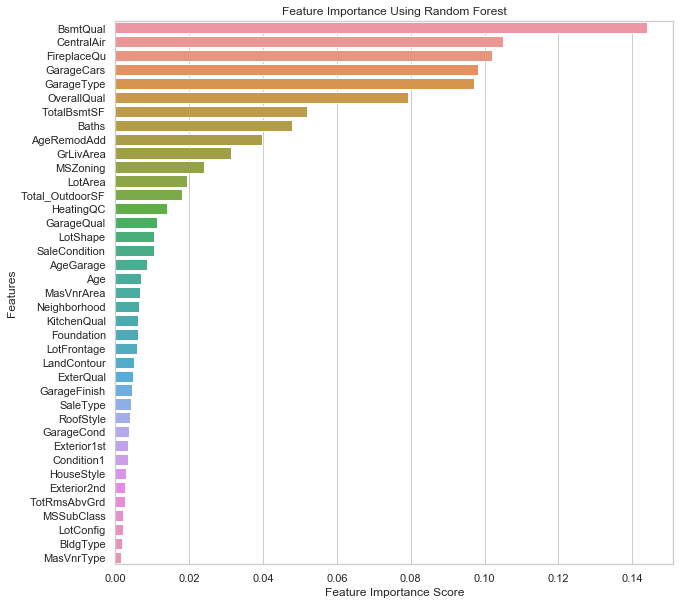

In [22]:
#create important and unimportant columns
feature_importance = 100.0 * (best_XGBR.feature_importances_ / best_XGBR.feature_importances_.max())
imp_col = X_train.columns[feature_importance >= 4]
unimp_col = X_train.columns[feature_importance < 4]
print(imp_col)

#feature importance graph
sorted_importance = sorted(zip(X.columns, best_XGBR.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance Using Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

### Repeat XGBOOST with reduced features

In [24]:
# Drop unimportant features
X_train.drop(unimp_col, axis=1, inplace=True)
X_test.drop(unimp_col, axis=1, inplace=True)

In [25]:
# hyperparamter tuning using grid search
xgbr_final = XGBRegressor()
grid_param2 = [{'max_depth': range(1, 6),
               'n_estimators':range(1000,10000,500),
               'learning_rate':[.001, .01, .1]}]

In [26]:
grid_search_xgbr2 = GridSearchCV(xgbr_final, grid_param2, cv=10, n_jobs=-1, verbose=1)
grid_search_xgbr2.fit(X_train, y_train)

print("RF Grid Search Best params: ", grid_search_xgbr2.best_params_)
print("RF Grid Search Best score: ", grid_search_xgbr2.best_score_)
print("RF Grid Search Best estimators: ", grid_search_xgbr2.best_estimator_)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 37.8min finished


RF Grid Search Best params:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 3000}
RF Grid Search Best score:  0.8869314619125657
RF Grid Search Best estimators:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [27]:
#record results using new best estimators
best_XGBR2 = grid_search_xgbr2.best_estimator_

y_train_pred_xgbr2 = best_XGBR2.predict(X_train)
RMSE_train2 = np.sqrt(mean_squared_error(y_train,y_train_pred_xgbr2))

y_test_pred_xgbr2 = best_XGBR2.predict(X_test)
RMSE_test2 = np.sqrt(mean_squared_error(y_test,y_test_pred_xgbr2))


print("R^2 for train data is: %.3f" %(grid_search_xgbr2.score(X_train, y_train)))
print("R^2 for test data is: %.3f" %(grid_search_xgbr2.score(X_test,y_test)))
print("-" * 50)
print('RMSE for train data is: %.3f' % RMSE_train)
print('RMSE for test data is: %.3f' % RMSE_test)

R^2 for train data is: 0.971
R^2 for test data is: 0.890
--------------------------------------------------
RMSE for train data is: 0.080
RMSE for test data is: 0.130
